# Rete Neurale Convoluzionale per il riconoscimento dei cartelli stradali e dei limiti di velocità
## Librerie da importare
I comandi che dovremo eseguire per importare e per installare tutte le librerie sono: 
> pip install numpy pandas matplotlib scikit-learn tensorflow tqdm
Le librerie da importare sono:
- **numpy**: è la libreria che utilizzeremo in python per gestire i vettori e le matrici. Le nostre immagini saranno matrici di dimensinoe 32x32x3, dove i 32 pixel indicano larghezza e altezza, mentre 3 sono i spazi di colore RGB
- **matplotlib**: è la libreria che useremo per fare i grafici e mostrare le immagini
- **pandas**: è la libreria che viene utilizzata per la manipolazione dei nostri dati e che ci permette di portarli in formati adatti alla rete
- **tensorflow**: è la libreria principale che utilizzeremo per costruire la nostra rete neurale convoluzionale
- **tqdm**: è la libreria che mostrerà la barra di avanzamento durante l'esecuzione di alcune operazioni

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Indichiamo tutti i percorsi principali dove andremo ad estrarre le nostre immagini e label di training e di test.<br>
Nel nostro caso le immagini sono tutti nella cartella del progetto del lavoro, quindi la path principale è `./`

In [3]:
# Percorsi principali
base_dir = "./"  # Cambia con il tuo percorso locale
train_dir = os.path.join(base_dir, "Train")
test_dir = os.path.join(base_dir, "Test")
meta_dir = os.path.join(base_dir, "Meta")
train_csv = os.path.join(base_dir, "Train.csv")
test_csv = os.path.join(base_dir, "Test.csv")

# Parametri globali
IMG_HEIGHT, IMG_WIDTH = 32, 32  # Dimensioni standardizzate delle immagini
NUM_CLASSES = 43  # Numero totale di classi nel dataset

# Data pre-processing (immagini di training)

Il codice implementa una funzione per il caricamento e la pre-elaborazione di immagini di training, utilizzando librerie Python come `os`, `tqdm` e `tensorflow.keras.preprocessing.image`. Ecco un riepilogo delle funzionalità principali:

## Importazione della libreria `tqdm`
(opzionale) La prima cosa da fare è quella di importare la libreria `tqdm` per mostrare una barra di avanzamento che mi mostra il caricamento delle immagini<br><br>

Dopo aver scaricato l'intera cartella contenente il dataset (German Traffic Sign Recognition Benchmark) dei cartelli stradali, dobbiamo importare tutte le immagini di training e tutte le immagini di test con le loro rispettive label. Abbiamo 39.209 immagini di training e 12.630 immagini di testing che successivamente caricheremo.<br>
Dovremo quindi creare due array che conterranno tutte le immagini di Training e un altro per le laber di training.
- X_train: è la struttura dati che contiene tutte le mie 39.209 immagini di training e sono matrici 32x32x3
- Y_train: è la struttura dati che contiene tutte le mie label corrispondenti alle classi. Le classi, ovvero, tutti i segnali stradali che la rete può distinguere sono 43.

### Dettagli di Implementazione
1. **Inizializzazione:** Creazione di due liste vuote:
   - `images` per memorizzare i dati delle immagini.
   - `labels` per le etichette corrispondenti.

2. **Iterazione sulle sottodirectory:**
   - Ogni sottodirectory rappresenta una classe ed è identificata da un nome numerico (`class_id`).
   - Per ogni immagine nella sottodirectory, viene creato il percorso completo.

3. **Caricamento e pre-elaborazione delle immagini:**
   - Le immagini vengono caricate utilizzando `load_img()` e ridimensionate a dimensioni fisse (`32x32x3`).
   - I dati vengono convertiti in array e normalizzati tra 0 e 1.
   - Ogni immagine e la relativa etichetta vengono aggiunte alle rispettive liste.

4. **Gestione delle eccezioni:**
   - Eventuali errori nel caricamento delle immagini vengono catturati e segnalati tramite `print`.

5. **Conversione in array NumPy:**
   - Le liste vengono convertite in array NumPy per un'elaborazione più efficiente.

### Uso della Funzione
- La funzione viene chiamata passando il percorso della directory di training (`train_dir`).
- Gli array risultanti (`X_train` e `y_train`) contengono rispettivamente i dati delle immagini e le etichette.

### Output
- Le forme di `X_train` e `y_train` vengono stampate per confermare il caricamento corretto del dataset.

In [4]:
from tqdm import tqdm

# Carica le immagini di training
def load_train_images(directory):
    # creazione di due liste vuote per immagini e etichette
    images = []
    labels = []

    # Itera su tutte le cartelle all'interno della directory
    for class_id in sorted(os.listdir(directory)):  
        # creazione di nuove sottodirectory per ogni classe
        class_dir = os.path.join(directory, class_id)
        if os.path.isdir(class_dir):
            # Itera su tutti i file all'interno della sottodirectory
            for img_name in os.listdir(class_dir):
                # crea il percorso completo dell'immagine
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Carica e ridimensiona l'immagine in 32x32x3
                    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                    img_array = img_to_array(img) / 255.0  # Normalizza tra 0 e 1
                    images.append(img_array)
                    labels.append(int(class_id))  # Usa il nome della cartella come etichetta
                except Exception as e:
                    print(f"Errore nel caricamento di {img_path}: {e}")
    return np.array(images), np.array(labels)

# Carica il dataset di training
X_train, y_train = load_train_images(train_dir)
print(f"Shape X_train: {X_train.shape}, Shape y_train: {y_train.shape}")

Shape X_train: (39209, 32, 32, 3), Shape y_train: (39209,)


Le nostre etichette verranno trasformate in una rappresentazione one-hot-encoding, ovvero, come un array binario con lunghezza pari al numero totale di classi

In [5]:
y_train_one_hot = to_categorical(y_train, NUM_CLASSES)
print(f"Shape y_train_one_hot: {y_train_one_hot.shape}")

Shape y_train_one_hot: (39209, 43)


Il codice eseguirà una divisione dei dati di training in input con quelli di validazione, sul totale di 39.209 immagini e avremo che:
- Immagini di training: 80% -> 31.367 
- Immagini di validazione: 20% -> 7.842

Questo ci serve semplicemente per monitorare le prestazioni del modello durante l'addestramento senza avere un'influenza sui parametri del modello

In [6]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=42
)
print(f"Shape X_train_split: {X_train_split.shape}, Shape X_val: {X_val.shape}")


Shape X_train_split: (31367, 32, 32, 3), Shape X_val: (7842, 32, 32, 3)


# Data pre-processing (immagini di testing)

Il codice seguente implementa una funzione per il caricamento e la pre-elaborazione di immagini di test da un dataset strutturato, utilizzando librerie Python come `os`, `pandas` e `tensorflow.keras.preprocessing.image`.

### Funzione `load_test_images(test_data, base_test_dir)`
La nostra funzione dovrà caricare le nostre immagini di test usufruendo di un file CSV che contiene i percorsi e le classi delle immagini. 
Le nostre immagini di test come detto precedentemente saranno delle matrici 32x32x3, che successivamente andremo a convertire in array e normalizzeremo tra 0 e 1 e avremo:
- **X_test:** che sarà l'array contenente tutte le nostre immagini di test 12.630
- **y_test:** che sarà l'array che contiene le etichette corrispondenti alle immagini di test
<br>
*Dovremo convertire come fatto precedentemente il nostro array di etichette in one-hot encoding, ovvero un formato binario che è compatibile con tutti i modelli di deep learning.

### Uso della Funzione
- La funzione viene chiamata passando il DataFrame del test (`test_data`) e il percorso base (`test_dir`).
- Gli array risultanti (`X_test` e `y_test`) contengono rispettivamente i dati delle immagini e le etichette.

### Output
- Le forme di `X_test` e `y_test` vengono stampate per confermare il caricamento corretto del dataset.

In [7]:
def load_test_images(test_data, base_test_dir):
    images = []
    labels = []
    for _, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
        # Correggi il percorso rimuovendo "Test/"
        corrected_path = row['Path'].replace("Test/", "").strip()
        img_path = os.path.join(base_test_dir, corrected_path)
        
        if os.path.exists(img_path):  # Verifica che il file esista
            try:
                # Carica e ridimensiona l'immagine
                img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                img_array = img_to_array(img) / 255.0  # Normalizzazione
                images.append(img_array)
                labels.append(row['ClassId'])
            except Exception as e:
                print(f"Errore nel caricamento di {img_path}: {e}")
        else:
            print(f"File non trovato: {img_path}")
    return np.array(images), np.array(labels)

# Carica il dataset di test
test_data = pd.read_csv(test_csv)  # Assicuriamoci che il file sia letto correttamente
X_test, y_test = load_test_images(test_data, test_dir)
y_test_one_hot = to_categorical(y_test, NUM_CLASSES)
print(f"Shape X_test: {X_test.shape}, Shape y_test: {y_test.shape}")


100%|██████████| 12630/12630 [00:03<00:00, 3810.28it/s]


Shape X_test: (12630, 32, 32, 3), Shape y_test: (12630,)


# Costruzione della Rete Neurale Convoluzionale (CNN)

Il nostro modello è una rete neurale convoluzionale (CNN), composta da 4 blocchi principali e 3 layer fully connected, dove in uscita abbiamo le nostre 43 classi. I layer sono disposti nel seguente modo:
- 1°Blocco:
  - layer convoluzionale 2D
  - layer di batch normalizzation:
  - layer di MaxPooling:
  - layer di dropout:

- 2°Blocco:
  - layer convoluzionale 2D
  - layer di batch normalizzation:
  - layer di MaxPooling:
  - layer di dropout:

- 3°Blocco:
  - layer convoluzionale 2D
  - layer di batch normalizzation:
  - layer di MaxPooling:
  - layer di dropout:

- 4°Blocco:
  - layer convoluzionale 2D
  - layer di batch normalizzation:
  - layer di MaxPooling:
  - layer di dropout:

- 5°layer: si tratta di un layer di flatten
- 6°7°8°: sono i nostri layer densi alternati a quelli di dropout


## Struttura del Modello (Approfondimento)
Il modello è composto da diversi blocchi convoluzionali seguiti da livelli completamente connessi e un livello di output.

### 1. **Blocco 1**
**1.1 Layer di Convoluzione**<br>
Nel primo blocco, all'inizio abbiamo un layer di convoluzione, che non fa altro che fare una convoluzione tra i pixel dell'immagine e **32 filtri** di dimensione 3x3. I filtri che sono utilizzati sono casuali e verranno applicati a tutti e 3 i canali.<br>
La funzione di attivazione sarà la RELU che preso in ingresso un valore negativo, restituisce 0, altrimenti restituisce il valore stesso e serve per introdurre la non linearità della rete per poter apprendere e rappresentare relazioni non lineari. Essendo che il kernel non lo possiamo sovrapporre a tutta l'immagine, perderemo i bordi  e la risultante sarà 30x30x32, dove perderemo due pixel in larghezza e altezza, e applicheremo i 32 filtri alle mie immagini
<br><br>

**Recap**
- Input: 32x32x3
- Operazione: convoluzione con 32 filtri 3x3
- Output: 30x30x32

**1.2 BatchNormalization layer**<br>
Con la `BatchNormalization` non faremo altro che accelerare la convergenza, normalizzando i miei output del layer precedente.

**1.3 MaxPooling2D Layer**<br>
Il terzo layer sarà un layer di pooling che ha lo scopo di dimezzare la dimensione dell'immagine. Perciò prende in considerazione una finestra (parte dell'immagine) composta da 2 pixel in altezza e larghezza (2x2) e memorizzando il valore del pixel con il valore più alto tra i 4 scelti.
- Input: 30x30x32
- Operazioe: Max Pooling con pool 2x2
- Output: 15x15x32

**1.4 Dropout Layer**<br>
Il layer di dropout con il tasso di 25% serve per ridurre il fenomeno di overfitting. Quello che faremo con il dropout è di chiedere alla rete di classificare i primi input solamente con il 75% dei neuroni disponibili in quel layer, questo serve per far sì che la rete si alleni a classificare utilizzando solamente alcuni neuroni disponibili, evitando quindi una sovra-specializzazione delle caratteristiche e permettendo alla rete di generalizzare su dati mai visti.<br><br>

**N.B.**Nei prossimi 2 blocchi, avremo la stessa struttura, quello che cambierà sarà solamente il numero di filtri e la percentuale di dropout.
### 2. **Blocco 2**
**`Conv2D(64, (3, 3), activation='relu')`**: Convoluzione 2D con 64 filtri 3x3
- Input: 15x15x32
- Operazione: Convoluzione con 64 filtri 3x3
- Output: 13x13x64

**`BatchNormalization()`**: Normalizza l'output del livello precedente.

**`MaxPooling2D((2, 2))`**: Pooling massimo.
- Input: 13x13x64
- Operazione: Max pooling con pool 2x2
- Output: 6x6x64

**`Dropout(0.3)`**: Dropout con un tasso del 30%.

### 3. **Blocco 3**
**`Conv2D(128, (3, 3), activation='relu')`**: Convoluzione 2D con 128 filtri. <br>
- Input: 6x6x64
- Operazione: Convoluzione con 128 filtri 3x3
- Output: 4x4x128

**`BatchNormalization()`**: Normalizza l'output del livello precedente. <br>

**`MaxPooling2D((2, 2))`**: Pooling massimo. <br>
- Input: 4x4x128
- Operazione: MaxPooling con pool 2x2
- Output: 2x2x128

**`Dropout(0.4)`**: Dropout con un tasso del 40%. <br>

### 4. **Fully-connected layer**
#### **Layer Flatten:**
Il layer flatten si tratta di un layer che prende in input un tensore multidimensionale e la trasforma da in un vettore monodimensionale per poi essere elaborata nei layer densi.
- Input: 2x2x128
- Operazione: Trasformazione di un tensore multidimensionale in un vettore monodimensionale
- Output: 512

#### **Dense Layer 256 neuroni (relu)**
Il primo layer denso riceverà in ingresso i 512 valori di input.<br>
La funzione di attivazione che sarà utilizzata per ogni neurone è la relu. è importante introdurre la non linearità alla rete per permettere alla rete di assolvere a compiti che non sono di natura binaria. La relu è una funzione che preso in ingresso un numero, restituisce 0 se questo numero è negativo, altrimenti il numero stesso<br>
Ogni neurone è connesso a tutti i neuroni del layer successivo e per evitare che il modello durante l'addestramento vada in overfitting, quindi specializzandosi fin troppo sui dati di training, e non essendo in grado di generalizzare su dati mai visti, useremo il dropout. <br>
Il dropout è una tecnica di regolarizzazione che ad ogni iterazione riduce il numero di neuroni di un certo layer che possono essere utilizzati per imparare le varie e rappresentazioni e per generalizzare. Il nostro tasso di dropout in questo layer è del 50%, quindi, su 512 neuroni, la rete ad ogni iterazione ne userà 256. Questo serve per specializzare la rete a compiere l'apprendimento solo con i neuroni disponibili, ed evitare che un neurone si specializzi troppo su determinati dati.

#### **Dense Layer 128 neuroni (relu)**
Il secondo layer denso è l'analogo del primo layer denso, differisce solamente nel numero di neuroni presenti. Avremo in totale 128 neuroni, di cui, grazie al dropout solamente la metà verrà impiegata per l'apprendimento ad ogni iterazione in modo casuale.
La funzione di attivazione sarà sempre la relu.

#### **(Output) Dense Layer 43 neuroni (soft max)**
Nel layer di output invece avremo 43 neuroni, di cui ognuna rappresenterà la classe di appartenenza dell'immagine, ovvero, il cartello specifico. Quindi è il layer che si occupa della classificazione finale in cui la nostra funzione di attivazione, diversamente dai layer precedenti, sarà la **softmax**.<br>
La softmax è una funzione che in ingresso prende un numero e che trasforma i valori prodotti dai 43 neuroni in una probabilità. In output ad ogni neurone quindi avremo la probabilità che la data immagine in input alla nostra Rete Neurale Artificiale appartenga a quella data classe.<br>
La somma di tutte le probabilità farà 1.

### **Compilazione del Modello**
**Ottimizzatore:** `adam` (adaptive moment estimation) per una convergenza rapida ed efficiente. <br>
**Funzione di perdita:** `categorical_crossentropy`, adatta per classificazione multiclasse. <br>
**Metriche:** `accuracy` per monitorare la precisione durante l'addestramento. <br>

In [8]:
model = Sequential([
    # Blocco 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Blocco 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Blocco 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten e Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,915 (1.01 MB)

 Trainable params: 263,467 (1.01 MB)

 Non-trainable params: 448 (1.75 KB)

### 1. **EarlyStopping**
- **Obiettivo:** Interrompere l'addestramento se le prestazioni sul set di validazione non migliorano per un certo numero di epoche consecutive.
  - `monitor='val_loss'`: Monitorerà la perdita sul set di validazione.
  - `patience=5`: Ha il compito di interrompere l'addestramento dopo 5 epoche senza miglioramento.
  - `restore_best_weights=True`: Ripristina i pesi del modello alla miglior epoca osservata.

### 2. **ModelCheckpoint**
- **Obiettivo:** Salvare automaticamente il modello quando le prestazioni sul set di validazione migliorano.
- **Parametri principali:**
  - `"best_model.keras"`: corrisponde al file in cui viene salvato il modello.
  - `save_best_only=True`: Non fa altro che salvare il modello solo se l'epoca corrente produce le migliori prestazioni sul set di validazione.
  - `monitor='val_loss'`: Serve per monitorare la perdita sul set di validazione.

## Addestramento del Modello
I parametri che abbiamo impostato per il training sono i seguenti:
- **`X_train_split, y_train_split`**: Set di addestramento suddiviso per il training.
- **`validation_data=(X_val, y_val)`**: Set di validazione per monitorare le prestazioni che corrisponde al 20% del set di training
- **`epochs=30`**: numero massimo di epoche di addestramento
- **`batch_size=64`**: corrisponde al numero di campioni processati per batch durante l'adddestramento (31367/64)=491 campioni circa per ogni batch
- **`callbacks=[early_stopping, model_checkpoint]`**: callback definiti gestire l'early stopping e il salvataggio del modello.

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.1193 - loss: 3.6328 - val_accuracy: 0.3613 - val_loss: 2.4915
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.4736 - loss: 1.6503 - val_accuracy: 0.8090 - val_loss: 0.6102
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6933 - loss: 0.9237 - val_accuracy: 0.9053 - val_loss: 0.3093
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7913 - loss: 0.6328 - val_accuracy: 0.9408 - val_loss: 0.2043
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8455 - loss: 0.4826 - val_accuracy: 0.9640 - val_loss: 0.1223
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8831 - loss: 0.3635 - val_accuracy: 0.9732 - val_loss: 0.0921
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8981 - loss: 0.3411 - val_accuracy: 0.9804 - val_loss: 0.0701
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9156 - loss: 0.2878 - 

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot, verbose=2)
print(f"Test Accuracy: {test_acc:.2f}")


395/395 - 1s - 3ms/step - accuracy: 0.9713 - loss: 0.1030
Test Accuracy: 0.97


# Visualizzazione delle Prestazioni del Modello

Il codice crea grafici per analizzare l'andamento dell'accuratezza e della perdita durante l'addestramento del modello.

## Interpretazione dei Grafici
1. **Grafico dell'Accuratezza**:
   - Permette di osservare come l'accuratezza del modello migliora durante l'addestramento.
   - Confronta l'accuratezza tra il training e la validazione per verificare eventuali problemi di overfitting.

2. **Grafico della Perdita**:
   - Mostra la riduzione della perdita durante l'addestramento.
   - Un gap crescente tra la perdita di training e validazione può indicare overfitting.

**Risultati**<br>
Quello che possiamo notare dai due grafici è che la rete sta apprendendo correttamente e non sta andando in overfitting, infatti, la curva di perdita e di accuratezza per training e validazione non si separano significativamente. Le 30 epoche non vengono svolte tutte, grazie all'earlystopping e la rete interrompe il training circa alla 25 epoca (dipende dal modello) 

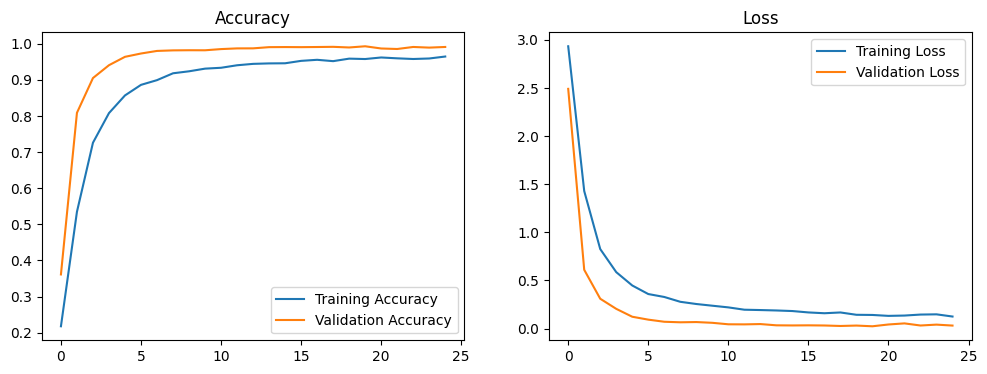

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()



### Confusion Matrix
Quello che si può vedere dalla matrice di confusione è che generalmente la rete neurale generalizza correttamente, ma ci sono delle classi per cui la confusione è circa del 10% rispetto i dati di testing in input. (es. classe 3 = limite dei 60km/h che confonde con classe 5 = limite dei 80km/h) questo perché alcuni cartelli sono esattamente identici ad altri e differiscono solamente per delle cifre

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


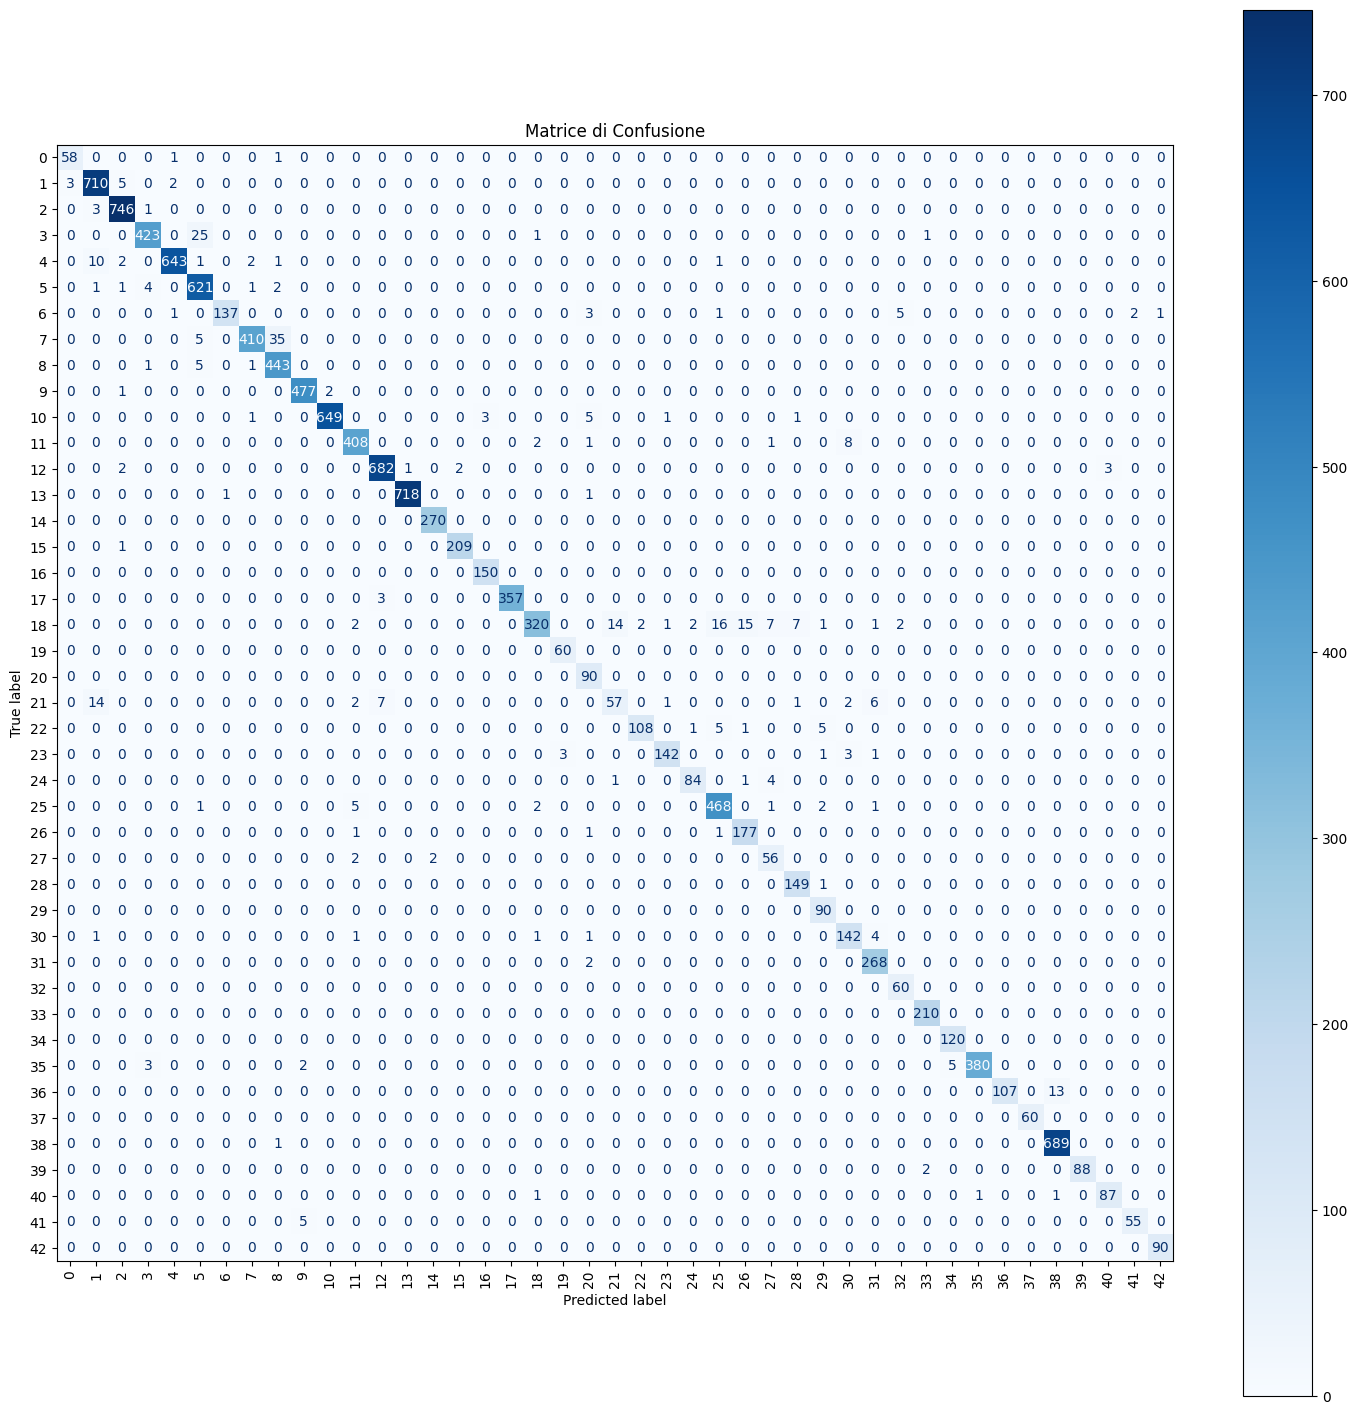

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predizioni sul test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Matrice di Confusione
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizzazione
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("Matrice di Confusione")
plt.show()


Visto che le label corrispondono a dei numeri e noi vogliamo attribuirgli una rappresentazione sintattica alle nostre etichette, con il significato del segnale etichettato, la cosa migliore da fare è quella di creare un array che per ogni etichetta, associ il suo significato.

In [13]:
# Dizionario delle etichette (esempio)
class_labels = {
    0: "Speed Limit (20km/h)",
    1: "Speed Limit (30km/h)",
    2: "Speed Limit (50km/h)",
    3: "Speed Limit (60km/h)",
    4: "Speed Limit (70km/h)",
    5: "Speed Limit (80km/h)",
    6: "End of Speed Limit (80km/h)",
    7: "Speed Limit (100km/h)",
    8: "Speed Limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}

# Predizioni Corrette
Quello che possiamoe notare è che la rete tende a riconoscere su 12630 immagini, circa 97% sbagliandone circa 300.
Questo è dovuto alla risoluzione di alcune immagini di test che sono completamente irriconoscibili per la rete.
- **Predizioni Corrette:** Il numero totale di predizioni corrette indica quanto bene il modello riesce a classificare il dataset di test.
- **Qualità del Modello:** Le immagini mostrate rappresentano esempi di classificazione riuscita, suggerendo che il modello ha imparato a distinguere correttamente alcune classi.
- **Classe Predetta vs Vera:** Dai titoli delle immagini si può verificare che l'etichetta vera e quella predetta siano effettivamente coincidenti per ogni immagine mostrata.

Numero di predizioni corrette: 12268


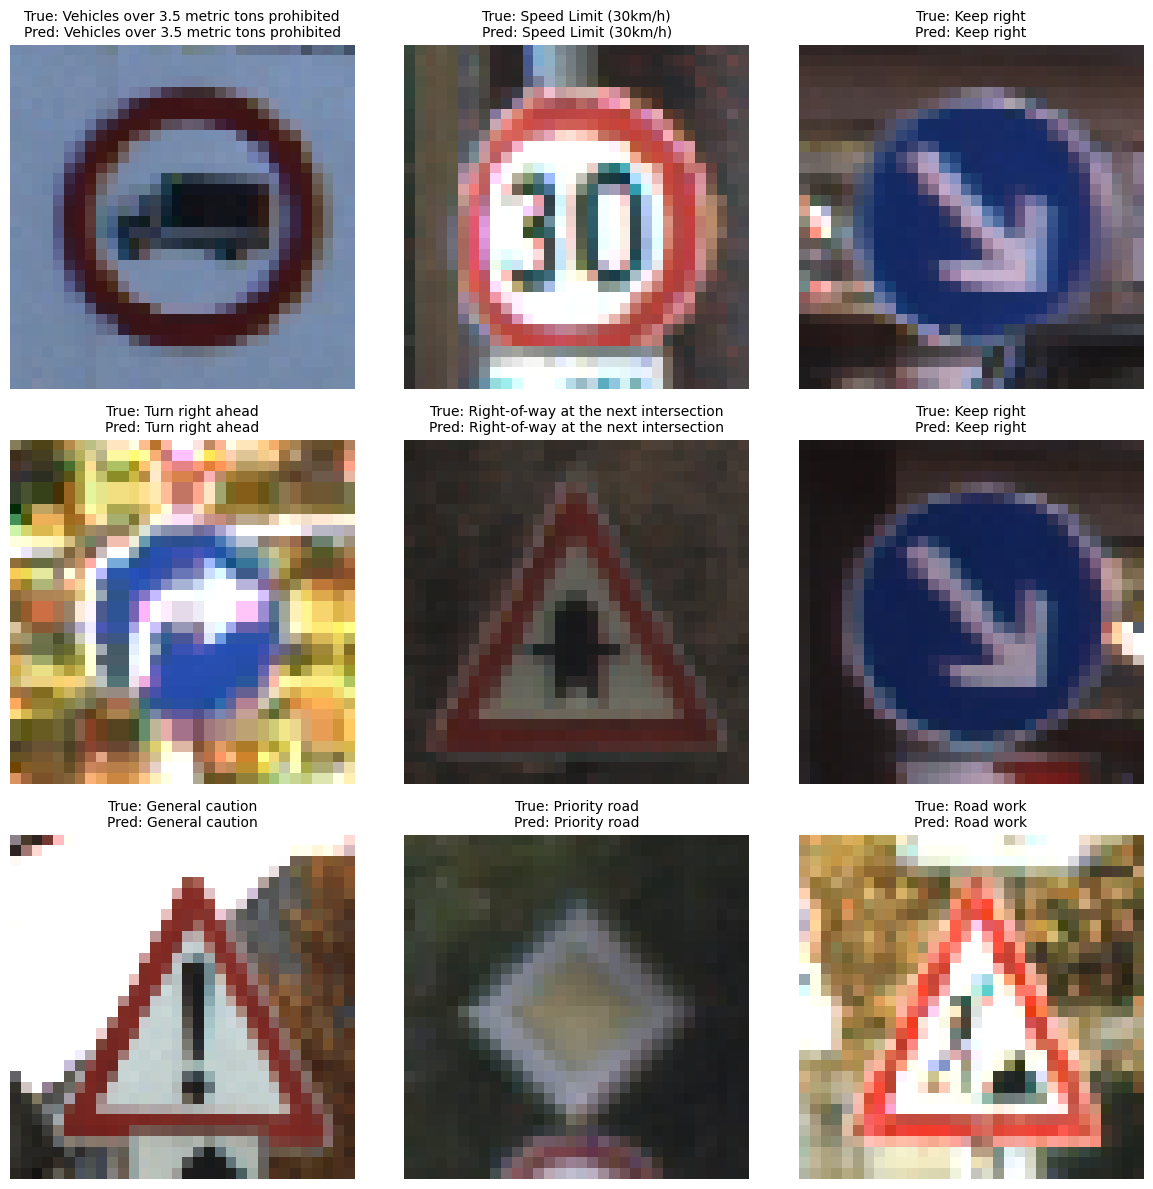

In [14]:
# Identifica le predizioni corrette
correct_indices = np.where(y_true_classes == y_pred_classes)[0]

# Mostra solo le immagini con predizioni corrette
print(f"Numero di predizioni corrette: {len(correct_indices)}")
plt.figure(figsize=(12, 12))
for i, idx in enumerate(correct_indices[:9]):  # Mostra un massimo di 9 predizioni corrette
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    true_label = class_labels[y_true_classes[idx]]  # Etichetta vera
    predicted_label = class_labels[y_pred_classes[idx]]  # Etichetta predetta
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Predizioni Sbagliate
Nel codice sotto è possibile notare come alcune predizioni sbagliate siano dovute alla bassa risoluzione di alcune immagini, dove, ad esempio i numeri dei cartelli stradali diventano completamente indistinguibili da altri cartelli simili.


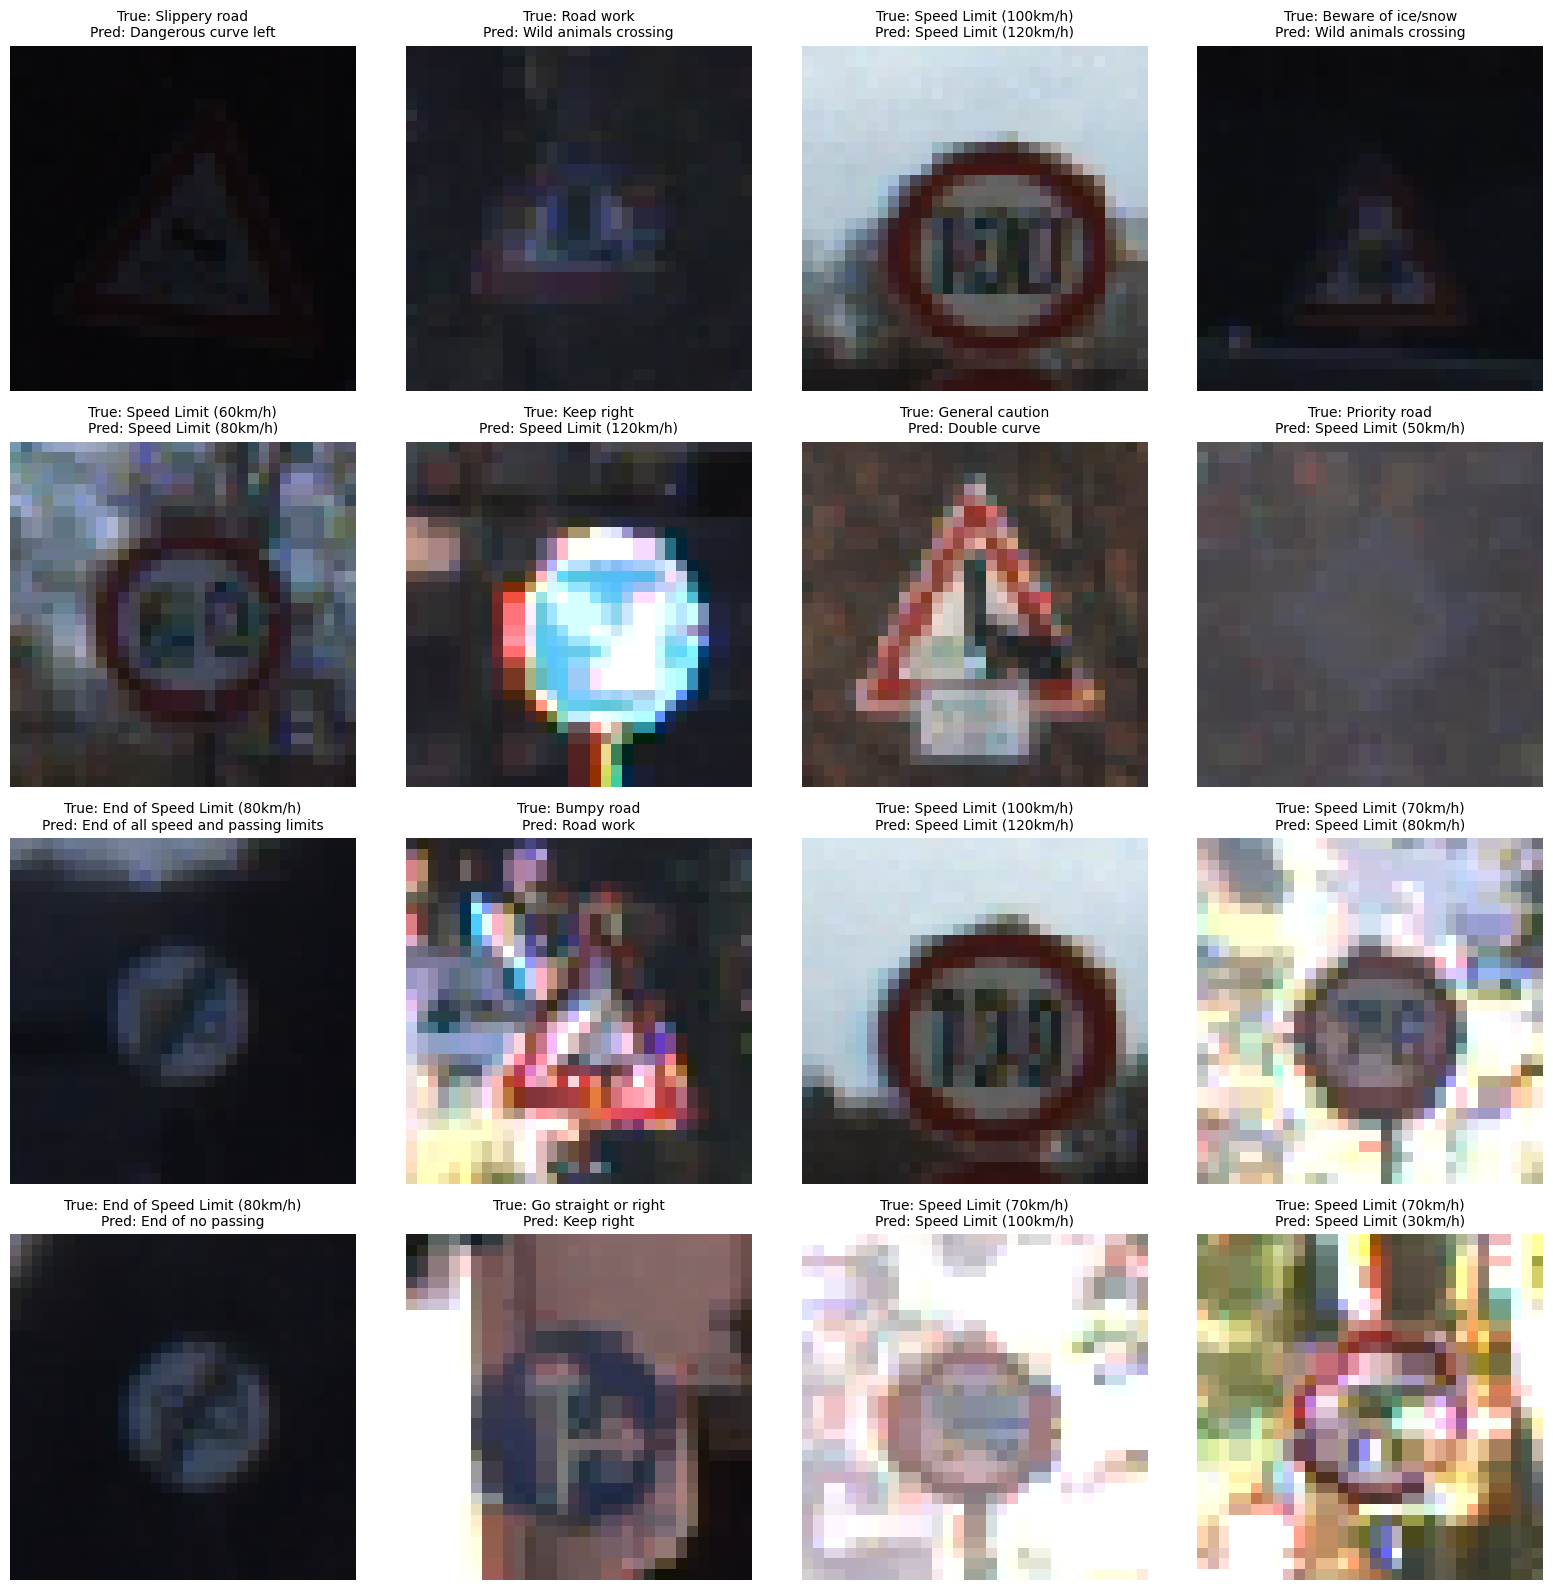

In [21]:
# Identifica le predizioni errate
wrong_indices = np.where(y_true_classes != y_pred_classes)[0]

# Visualizzazione delle Predizioni Errate con Etichette Testuali
plt.figure(figsize=(16, 16))
for i, idx in enumerate(wrong_indices[:16]):  # Mostra un massimo di 9 errori
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_test[idx])
    true_label = class_labels[y_true_classes[idx]]
    predicted_label = class_labels[y_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()